In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
colors = [(170/255.,51/255.,51/255.),(51/255.,102/255.,170/255.)]

In [2]:
sets = ['A','B','C']
columns = ['x0','x1','y']
dict_train = dict(zip(sets,[pd.read_csv('Data/classification'+s+'.train',sep='\t', names=columns) for s in sets]))
dict_test  = dict(zip(sets,[pd.read_csv('Data/classification'+s+'.test', sep='\t', names=columns) for s in sets]))

## 1.  Generative model (LDA)

In [20]:
LDA = dict()
errors = pd.DataFrame(columns=['train','test'],index=['A','B','C'])
for key in sets:
    #reading data
    X = dict_train[key][['x0','x1']]
    y = dict_train[key]['y']
    #calculating estimates
    pi=y.mean()
    mu_0 = X[y==0].mean(axis=0).values
    mu_1 = X[y==1].mean(axis=0).values
    mu   = np.zeros(X.shape)
    mu[y==0] = np.repeat([mu_0],sum(y==0),axis=0)
    mu[y==1] = np.repeat([mu_1],sum(y==1),axis=0)
    sigma = np.dot((X-mu).T,X-mu)/len(y)
    A = np.linalg.inv(sigma)
    u = np.dot(A,np.subtract(mu_0,mu_1))
    c = np.log(pi/(1-pi))+0.5*np.dot(mu_0,np.dot(A,mu_0))-0.5*np.dot(mu_1,np.dot(A,mu_1))
    #storing estimates and training errors
    LDA[key]=(u,c)
    errors.loc[key]['train'] = sum(y!= (np.dot(X,u)-c<0))/float(len(y))

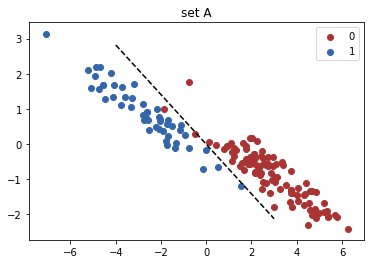

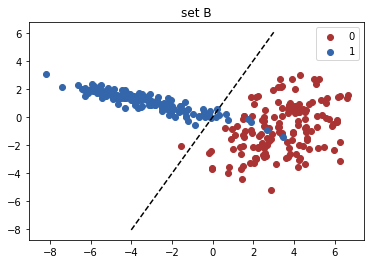

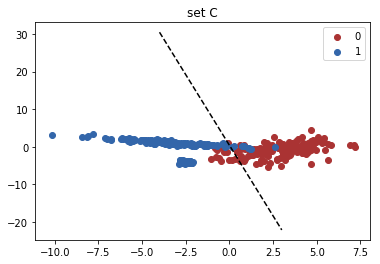

In [21]:
def line(x,u,c):
    return -(u[0]/u[1])*x + c/u[1]
for key in sets:
    #reading data
    X = dict_train[key][['x0','x1']]
    y = dict_train[key]['y']
    u,c = LDA[key]
    #plots of the training set and the decision boundaries
    plt.figure()
    plt.scatter(x=X[y==0].x0,y=X[y==0].x1,c=colors[0],label='0')
    plt.scatter(x=X[y==1].x0,y=X[y==1].x1,c=colors[1],label='1')
    plt.plot(np.arange(-4,4),line(np.arange(-4,4),u,c), linestyle='--', color='k')
    plt.legend()
    plt.title('set '+key)

In [22]:
for key in sets:
    #reading data
    X = dict_test[key][['x0','x1']]
    y = dict_test[key]['y']
    u,c = LDA[key]
    #calculating test errors
    predict = np.dot(X,u)-c<0
    errors.loc[key]['test'] = sum(y!=predict)/float(len(y))
print(errors.applymap('{:,.4f}'.format))

    train    test
A  0.0133  0.0200
B  0.0300  0.0415
C  0.0550  0.0423


## 2. Logistic regression

In [23]:
# helper functions for IRLS
#def sigmoid(w,X):
#    return 1/(1+np.exp(-np.dot(X,w)))
def sigmoid(w,X):
    # avoids overflow in exp
    t = np.dot(X,w)
    idx = t > 0
    out = np.empty(t.size, dtype=np.float)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out
def D(w,X):
    s = sigmoid(w,X)
    return np.diag(s*(1-s))
def hess(w,X):
    #inverse of the hessian matrix
    hess=np.dot(X.T,np.dot(D(w,X),X))
    return -np.linalg.pinv(hess)
def update(w,y,X):
    return w-np.dot(np.dot(hess(w,X),X.T),y-sigmoid(w,X))
def line(x,w):
    return -(w[0]/w[1])*x - w[2]/w[1]

In [24]:
max_inters=10000
LogR = dict()
errors = pd.DataFrame(columns=['train','test'],index=['A','B','C'])
for key in sets:
    #reading data
    data = dict_train[key]
    X = data[['x0','x1']].copy()
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    #IRLS
    w=np.ones(3)
    w_new = np.zeros(3)
    iters=0
    while(np.linalg.norm(w-w_new)>1e-6 and iters<max_inters):
        tmp=w_new
        w_new=update(w_new,y,X)
        w=tmp
        iters+=1
    print(w_new,iters, sep=', ')
    #storing estimates and training errors
    LogR[key] = w_new
    errors.loc[key]['train'] = sum(y!=(np.dot(X,w)>0))/float(len(y))

[-1507.52864112 -2604.64543592  -271.68335718], 10000
[-1.70518586  1.02378538  1.34959157], 9
[-2.2032324   0.70926562  0.95918885], 9


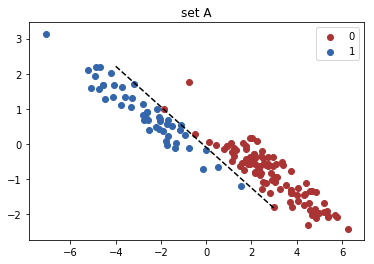

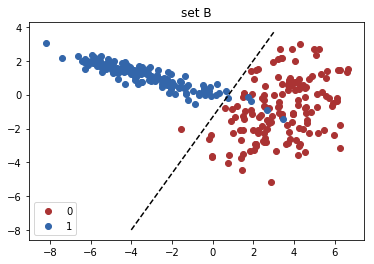

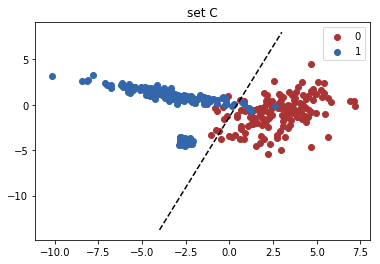

In [25]:
for key in sets:
    #reading data
    data = dict_train[key]
    X = data[['x0','x1']].copy()
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    w = LogR[key]
    #plotting the training set and the decision boundaries
    plt.figure()
    plt.scatter(x=data[y==0].x0,y=data[y==0].x1,c=colors[0],label='0')
    plt.scatter(x=data[y==1].x0,y=data[y==1].x1,c=colors[1],label='1')
    plt.plot(np.arange(-4,4),line(np.arange(-4,4),w), linestyle='--', color='k')
    plt.legend()
    plt.title('set '+key)

In [26]:
for key in sets:
    #reading data
    data = dict_test[key]
    X = data[['x0','x1']]
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    w = LogR[key]
    #test errors
    predict = np.dot(X,w)>0
    errors.loc[key]['test'] = sum(y!=predict)/float(len(y))
print(errors.applymap('{:,.4f}'.format))

    train    test
A  0.0000  0.0347
B  0.0200  0.0430
C  0.0400  0.0227


## 3. Linear regression

In [27]:
def line(x,w):
    return -(w[0]/w[1])*x - w[2]/w[1]+0.5/w[1]

LinR = dict()
errors = pd.DataFrame(columns=['train','test'],index=['A','B','C'])
for key in sets:
    #reading data
    data = dict_train[key]
    X = data[['x0','x1']].copy()
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    #calculating estimates
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    #storing estimates and traning errors
    LinR[key] = w
    errors.loc[key]['train'] = sum(y!=(np.dot(X,w)>0.5))/float(len(y))

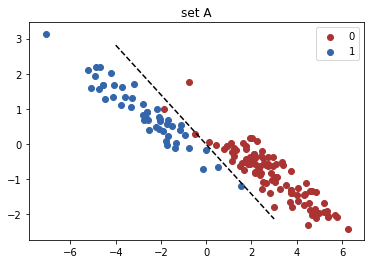

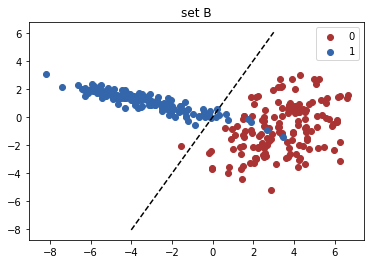

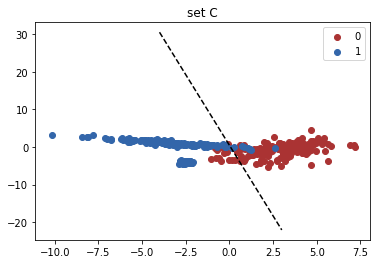

In [28]:
for key in sets:
    #reading data
    data = dict_train[key]
    X = data[['x0','x1']].copy()
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    w = LinR[key]
    #plotting the training sets and the decision boundaries
    a=-w[0]/w[1]
    plt.figure()
    plt.scatter(x=data[y==0].x0,y=data[y==0].x1,c=colors[0],label='0')
    plt.scatter(x=data[y==1].x0,y=data[y==1].x1,c=colors[1],label='1')
    plt.plot(np.arange(-4,4),line(np.arange(-4,4),w), linestyle='--', color='k')
    plt.legend()
    plt.title('set '+key)

In [29]:
for key in sets:
    #reading data
    data = dict_test[key]
    X = data[['x0','x1']]
    X['x2'] = pd.Series(np.ones(len(X)))
    X = X.values
    y = data['y']
    w = LinR[key]
    #test errors
    predict = np.dot(X,w)>0.5
    errors.loc[key]['test'] = sum(y!=predict)/float(len(y))
print(errors.applymap('{:,.4f}'.format))

    train    test
A  0.0133  0.0207
B  0.0300  0.0415
C  0.0550  0.0423


## 4. QDA model

In [30]:
QDA = dict()
def curve(x0,x1, mu_0, A_0, mu_1, A_1, pi):
    # curve = 0 is the decision boundary, this function is vectorized and set for the plt.contour function
    def g(arr):
        return (np.dot(arr-mu_1,np.dot(A_1,(arr-mu_1).T)) - np.dot(arr-mu_0,np.dot(A_0,(arr-mu_0).T))).diagonal()-2*np.log(pi/(1-pi))
    if(len(x0.shape)==1 and len(x1.shape)==1):
        arr = np.c_[x0,x1]
        return g(arr)
    else:
        res = np.zeros(x0.shape)
        for i in range(len(x0)):
            arr = np.c_[x0[i],x1[i]]
            res[i] = g(arr)
        return res
errors = pd.DataFrame(columns=['train','test'],index=['A','B','C'])
for key in sets:
    #reading data
    X = dict_train[key][['x0','x1']]
    y = dict_train[key]['y']
    #calculating estimates
    pi=y.mean()
    mu_0 = X[y==0].mean(axis=0).values
    mu_1 = X[y==1].mean(axis=0).values
    sigma_0 = np.cov(X[y==0].values.T,ddof=0)
    sigma_1 = np.cov(X[y==1].values.T,ddof=1)
    A_0 = np.linalg.inv(sigma_0)
    A_1 = np.linalg.inv(sigma_1)
    #storing estimates and training errors
    QDA[key]=(mu_0,A_0,mu_1,A_1,pi)
    x0 = X.values[:,0]
    x1 = X.values[:,1]
    errors.loc[key]['train'] = sum(y!= (curve(x0,x1, mu_0, A_0, mu_1, A_1,pi)<0))/float(len(y))

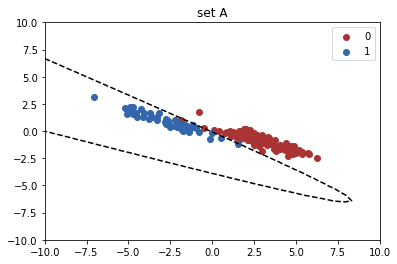

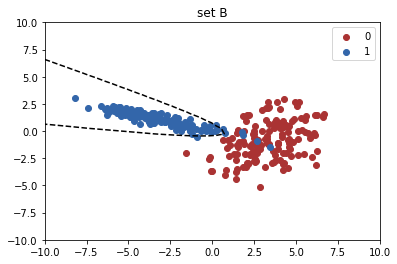

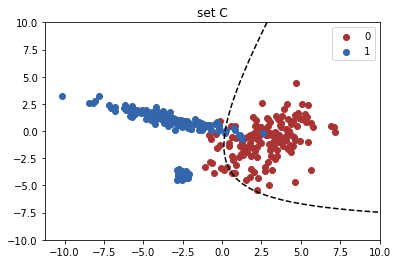

In [31]:
for key in sets:
    #reading data
    X = dict_train[key][['x0','x1']]
    y = dict_train[key]['y']
    mu_0,A_0,mu_1,A_1,pi = QDA[key]
    #plotting training sets and decision boundaries
    x0 = np.linspace(-10,10,40)
    x1 = np.linspace(-10,10,40)
    x0, x1 = np.meshgrid(x0,x1)
    plt.figure()
    plt.scatter(x=X[y==0].x0,y=X[y==0].x1,c=colors[0],label='0')
    plt.scatter(x=X[y==1].x0,y=X[y==1].x1,c=colors[1],label='1')
    plt.contour(x0,x1,curve(x0,x1, mu_0, A_0, mu_1, A_1, pi),[0], linestyles='--',colors='k')
    plt.legend()
    plt.title('set '+key)

In [32]:
for key in sets:
    #reading data
    X = dict_test[key][['x0','x1']]
    y = dict_test[key]['y']
    mu_0,A_0,mu_1,A_1,pi = QDA[key]
    #calculating test errors
    x0 = X.values[:,0]
    x1 = X.values[:,1]
    predict = (curve(x0,x1, mu_0, A_0, mu_1, A_1,pi)<0)
    errors.loc[key]['test'] = sum(y!=predict)/float(len(y))
print(errors.applymap('{:,.4f}'.format))

    train    test
A  0.0067  0.0187
B  0.0233  0.0230
C  0.0525  0.0403
